In [1]:
import os
import shutil
import random
from glob import glob
import shutil

# Individual Folder Images count

In [2]:
# Define the base directory where noisy image folders are located
base_dir = 'Data/Images/'


# Iterate through each subfolder in the root directory
for folder_name in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, folder_name)
    
    # Check if it's a directory
    if os.path.isdir(folder_path):
        # Count the number of files in the directory
        file_count = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
        print(f"{folder_name}: {file_count} images")

Defocus-blur_L5: 3000 images
Speckle-noise_L4: 3000 images
Zoom-Blur_L1: 3000 images
Contrast_L5: 3000 images
Defocus-blur_L1: 3000 images
Brightness_L3: 3000 images
Gaussian-noise_L3: 3000 images
Shot-noise_L5: 3000 images
Grayscale: 3000 images
JPEG-compression_L3: 3000 images
Spatter_L1: 3000 images
Elastic_L4: 3000 images
Saturation_L4: 3000 images
Zoom-Blur_L3: 3000 images
Shot-noise_L1: 3000 images
Impulse-noise_L5: 3000 images
Shot-noise_L3: 3000 images
Spatter_L5: 3000 images
Saturation_L5: 3000 images
Elastic_L2: 3000 images
Snow_L5: 3000 images
Defocus-blur_L4: 3000 images
Impulse-noise_L2: 3000 images
Defocus-blur_L2: 3000 images
Impulse-noise_L1: 3000 images
Contrast_L4: 3000 images
Elastic_L5: 3000 images
Zoom-Blur_L5: 3000 images
Grayscale-Inverse: 3000 images
Saturation_L2: 3000 images
Pixelate_L5: 3000 images
JPEG-compression_L4: 3000 images
Speckle-noise_L1: 3000 images
Contrast_L2: 3000 images
Speckle-noise_L3: 3000 images
Gaussian-noise_L1: 3000 images
Pixelate_L2: 3

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import time
from PIL import Image
import random

In [4]:
clean_dir = 'filtered_images/'
noisy_base_dir = 'Shot/'

# Creating Clean and Noisy Image Pair

In [5]:
class DenoisingDataset(Dataset):
    def __init__(self, clean_dir, noisy_base_dir, transform=None):
        """
        Args:
            clean_dir (string): Directory with all the clean images.
            noisy_base_dir (string): Directory with subfolders for each noise type, and inside each noise type, folders for severity levels.
            transform (callable, optional): Optional transform to be applied on a sample (e.g., ToTensor, Normalize).
        """
        self.clean_dir = clean_dir
        self.noisy_base_dir = noisy_base_dir
        self.transform = transform
        self.clean_images = sorted(os.listdir(clean_dir))
        
        self.noisy_images = []
        # for noise_type in self.noise_types:
        for severity_level in range(1, 6):  # Assuming L1 to L5
            noisy_folder = os.path.join(noisy_base_dir, f'L{severity_level}')
            print(noisy_folder)
            noisy_images = sorted(os.listdir(noisy_folder))
            print(noisy_images)
            self.noisy_images.extend([(os.path.join(noisy_folder, img), os.path.join(clean_dir, img)) for img in noisy_images])

    def __len__(self):
        return len(self.noisy_images)
    
    def __getitem__(self, idx):
        noisy_path, clean_path = self.noisy_images[idx]
        noisy_image = Image.open(noisy_path).convert('RGB')
        clean_image = Image.open(clean_path).convert('RGB')

        if self.transform:
            noisy_image = self.transform(noisy_image)
            clean_image = self.transform(clean_image)

        return noisy_image, clean_image

In [6]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [7]:
# Initialize the dataset
dataset = DenoisingDataset(clean_dir=clean_dir, 
                           noisy_base_dir=noisy_base_dir,
                           transform=transform)

Shot/L1
['COCO_val2014_000000000042.jpg', 'COCO_val2014_000000000073.jpg', 'COCO_val2014_000000000074.jpg', 'COCO_val2014_000000000133.jpg', 'COCO_val2014_000000000136.jpg', 'COCO_val2014_000000000139.jpg', 'COCO_val2014_000000000143.jpg', 'COCO_val2014_000000000164.jpg', 'COCO_val2014_000000000192.jpg', 'COCO_val2014_000000000196.jpg', 'COCO_val2014_000000000241.jpg', 'COCO_val2014_000000000257.jpg', 'COCO_val2014_000000000283.jpg', 'COCO_val2014_000000000285.jpg', 'COCO_val2014_000000000294.jpg', 'COCO_val2014_000000000328.jpg', 'COCO_val2014_000000000338.jpg', 'COCO_val2014_000000000357.jpg', 'COCO_val2014_000000000359.jpg', 'COCO_val2014_000000000360.jpg', 'COCO_val2014_000000000387.jpg', 'COCO_val2014_000000000395.jpg', 'COCO_val2014_000000000397.jpg', 'COCO_val2014_000000000400.jpg', 'COCO_val2014_000000000415.jpg', 'COCO_val2014_000000000428.jpg', 'COCO_val2014_000000000459.jpg', 'COCO_val2014_000000000472.jpg', 'COCO_val2014_000000000474.jpg', 'COCO_val2014_000000000486.jpg', '

In [8]:
# Check if the correct noisy-clean pairs are returned
def test_denoising_dataset(dataset, num_samples=3001):
    for i in range(num_samples):
        noisy_image_path, clean_image_path = dataset.noisy_images[i]  # Get the file paths of noisy and clean images
        
        # Extract file names from the paths
        noisy_folder_name = "/".join(noisy_image_path.split('/')[-3:-1])  # Folder name of noisy image
        noisy_image_name = noisy_image_path.split('/')[-1]  # File name of noisy image
        
        clean_folder_name = clean_image_path.split('/')[-2]  # Folder name of clean image
        clean_image_name = clean_image_path.split('/')[-1]  # File name of clean image
        
        # Print folder and file names to confirm matching
        print(f"Clean Image: Folder = {clean_folder_name}, Image = {clean_image_name}")
        print(f"Noisy Image: Folder = {noisy_folder_name}, Image = {noisy_image_name}\n")

# Test the dataset to see 5 random noisy-clean image file pairs
test_denoising_dataset(dataset, num_samples=3001)


Clean Image: Folder = filtered_images, Image = COCO_val2014_000000000042.jpg
Noisy Image: Folder = Shot/L1, Image = COCO_val2014_000000000042.jpg

Clean Image: Folder = filtered_images, Image = COCO_val2014_000000000073.jpg
Noisy Image: Folder = Shot/L1, Image = COCO_val2014_000000000073.jpg

Clean Image: Folder = filtered_images, Image = COCO_val2014_000000000074.jpg
Noisy Image: Folder = Shot/L1, Image = COCO_val2014_000000000074.jpg

Clean Image: Folder = filtered_images, Image = COCO_val2014_000000000133.jpg
Noisy Image: Folder = Shot/L1, Image = COCO_val2014_000000000133.jpg

Clean Image: Folder = filtered_images, Image = COCO_val2014_000000000136.jpg
Noisy Image: Folder = Shot/L1, Image = COCO_val2014_000000000136.jpg

Clean Image: Folder = filtered_images, Image = COCO_val2014_000000000139.jpg
Noisy Image: Folder = Shot/L1, Image = COCO_val2014_000000000139.jpg

Clean Image: Folder = filtered_images, Image = COCO_val2014_000000000143.jpg
Noisy Image: Folder = Shot/L1, Image = CO

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import time

In [10]:
!pip install deepinv

In [11]:
from deepinv.models import DRUNet

/home/ndag/anaconda3/envs/sks/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
model = DRUNet(in_channels=3, out_channels=3, pretrained='download', device='cuda')

In [13]:
# Set the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [14]:
model = model.to(device)
model

DRUNet(
  (m_head): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (m_down1): Sequential(
    (0): ResBlock(
      (res): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
    )
    (1): ResBlock(
      (res): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
    )
    (2): ResBlock(
      (res): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
    )
    (3): ResBlock(
      (res): Sequential(
        (0): Conv2

In [15]:
example_input = torch.randn(30, 3, 224, 224).to(device)
with torch.no_grad():
    output = model(example_input,0.0)
print(output.shape)

torch.Size([30, 3, 224, 224])


In [16]:
total_size = len(dataset)
total_size

15000

In [17]:
train_size = int(0.70 * total_size)  # 70% for training
val_size = int(0.15 * total_size)    # 15% for validation
test_size = total_size - train_size - val_size  # Remaining 15% for testing

In [18]:
# Split the dataset into train, validation, and test sets
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [19]:
print(len(train_dataset))
print(len(test_dataset))
print(len(val_dataset))

10500
2250
2250


In [21]:
# Define batch size
batch_size = 30

In [22]:
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [23]:
!pip install matplotlib

In [24]:
import matplotlib.pyplot as plt
import numpy as np

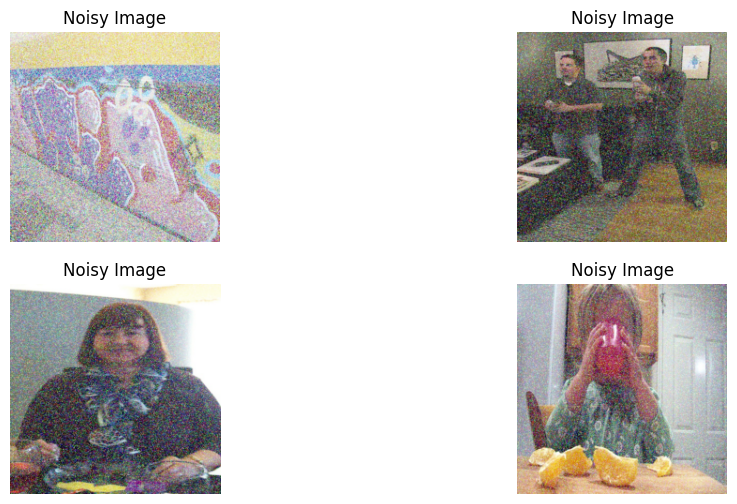

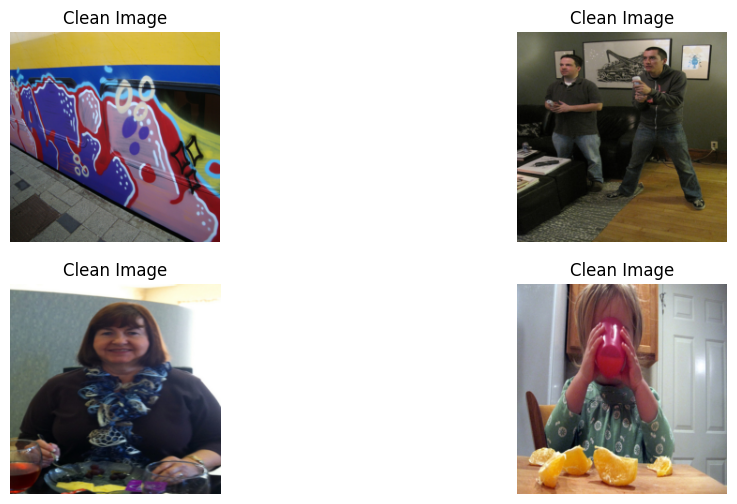

In [25]:
def imshow(img):
    # Convert tensor to numpy array, and unnormalize if needed
    img = img.numpy().transpose((1, 2, 0))  # Change from CxHxW to HxWxC
    img = np.clip(img, 0, 1)  # Ensure values are in [0, 1]
    plt.imshow(img)
    plt.axis('off')

# Get a batch of training images
data_iter = iter(train_loader)
noisy_images, clean_images = next(data_iter)

# Plot some images
num_images = 4  # Number of images to display
plt.figure(figsize=(12, 6))

for i in range(num_images):
    plt.subplot(2, num_images // 2, i + 1)
    imshow(noisy_images[i])
    plt.title('Noisy Image')
    
plt.figure(figsize=(12, 6))

for i in range(num_images):
    plt.subplot(2, num_images // 2, i + 1)
    imshow(clean_images[i])
    plt.title('Clean Image')

plt.show()


In [26]:
# Print dataset sizes
print(f"Train dataset size: {len(train_dataset)} images")
print(f"Validation dataset size: {len(val_dataset)} images")
print(f"Test dataset size: {len(test_dataset)} images")

Train dataset size: 10500 images
Validation dataset size: 2250 images
Test dataset size: 2250 images


In [27]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import time

In [28]:
def calculate_metrics(outputs, clean_images):
    """Calculate PSNR and SSIM between outputs and clean images."""
    batch_size = outputs.size(0)
    # print(batch_size)
    psnr_values = []
    ssim_values = []

    for i in range(batch_size):
        # Reshape images to (224, 224, 3) if they are flattened
        output_image = outputs[i].cpu().detach().numpy().reshape(224, 224, 3)
        clean_image = clean_images[i].cpu().detach().numpy().reshape(224, 224, 3)

        # Calculate PSNR
        psnr_values.append(psnr(clean_image, output_image, data_range=clean_image.max() - clean_image.min())) # stores psnr values for each image in the batch
        
        # Calculate SSIM
        ssim_values.append(ssim(clean_image, output_image, data_range=clean_image.max() - clean_image.min(), multichannel=True, win_size=3)) # stores ssim values for each image in the batch

    return np.mean(psnr_values), np.mean(ssim_values)

In [29]:
# Example: iterate through the DataLoader
for images, labels in train_loader:
    print(f"Batch size: {images.size(0)}, Clean image shape: {images.size()}, Noisy image shape: {labels.size()}")
    break

Batch size: 30, Clean image shape: torch.Size([30, 3, 224, 224]), Noisy image shape: torch.Size([30, 3, 224, 224])


In [30]:
# Number of epochs
num_epochs = 50
learning_rate = 0.0001

In [31]:
train_loss_history = []  # To store training loss for each epoch
val_loss_history = []    # To store validation loss for each epoch

In [32]:
# Define the training function
def train_drunet(drunet, train_loader, val_loader, num_epochs, learning_rate):
    drunet.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(drunet.parameters(), lr=learning_rate)
    
    best_val_loss = float('inf')  # Initialize to infinity
    best_epoch = 0  # To keep track of which epoch had the best model
    early_stop_patience = 10
    patience_counter = 0
    
    
    for epoch in range(num_epochs):
        start_time = time.time()
        
        # --- TRAINING PHASE ---
        drunet.train() # Set the model to training mode
        total_loss = 0.0
        
        
        for noisy_images, clean_images in train_loader:
            noisy_images = noisy_images.to(device)
            clean_images = clean_images.to(device)
            
            # Check shapes
            # print(f'Noisy images shape: {noisy_images.shape}')  # Should be (B, 3, 224, 224) or (B, C, H, W)
            
            # Forward pass
            outputs = drunet(noisy_images,0.0)
            loss = criterion(outputs, clean_images)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item() * noisy_images.size(0)
            
        avg_train_loss = total_loss / len(train_loader)
        train_loss_history.append(avg_train_loss)  # Store train loss
        
        # Validation phase
        drunet.eval() # Set the model to evaluation mode
        val_loss = 0.0
        total_psnr = 0.0
        total_ssim = 0.0
        
        with torch.no_grad():
            for noisy_images, clean_images in val_loader:
                noisy_images = noisy_images.to(device)
                clean_images = clean_images.to(device)

                # Forward pass: Get model predictions
                outputs = drunet(noisy_images, 0.0)
                loss = criterion(outputs, clean_images)
                
                # Accumulate the validation loss
                val_loss += loss.item()*noisy_images.size(0)
                
                # print(f"Outputs shape: {outputs.shape}, Clean images shape: {clean_images.shape}")
                psnr_value, ssim_value = calculate_metrics(outputs, clean_images)
                total_psnr += psnr_value
                total_ssim += ssim_value
        
        avg_val_loss = val_loss / len(val_loader)
        val_loss_history.append(avg_val_loss)  # Store validation loss
        
        avg_psnr = total_psnr / len(val_loader)
        avg_ssim = total_ssim / len(val_loader)
        
        # Check if this is the best validation loss so far
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_epoch = epoch + 1
            patience_counter = 0  # Reset patience counter if validation improves
            torch.save(drunet.state_dict(), 'Shot_drunet_run1.pt')  # Save the model
            print(f'Saved best model at epoch {best_epoch} with validation loss: {best_val_loss:.4f}')
        else:
            patience_counter += 1
            
        # Early stopping condition
        if patience_counter >= early_stop_patience:
            print(f'Early stopping at epoch {epoch+1} due to no improvement in validation loss for {early_stop_patience} consecutive epochs.')
            break

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}')
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Average PSNR: {avg_psnr:.4f}, Average SSIM: {avg_ssim:.4f}')
        print(f'Time taken: {time.time() - start_time:.2f} seconds\n')
    print(f"Training complete. Best model saved at epoch {best_epoch} with validation loss: {best_val_loss:.4f}.")

In [33]:
def evaluate_model_on_test(drunet, test_loader):
    # Load the best model saved during training
    drunet.load_state_dict(torch.load('Shot_drunet_run1.pt'))
    drunet.eval()
    test_loss = 0
    total_psnr = 0
    total_ssim = 0
    criterion = nn.MSELoss()

    with torch.no_grad():
        for noisy_images, clean_images in test_loader:  # Use test_loader here
            noisy_images = noisy_images.to(device)
            clean_images = clean_images.to(device)

            outputs = drunet(noisy_images,0.0)
            loss = criterion(outputs, clean_images)
            test_loss += loss.item()*noisy_images.size(0)
            # print(test_loss)

            psnr_value, ssim_value = calculate_metrics(outputs, clean_images)
            total_psnr += psnr_value
            total_ssim += ssim_value

    avg_test_loss = test_loss / len(test_loader)
    avg_psnr = total_psnr / len(test_loader)
    avg_ssim = total_ssim / len(test_loader)

    print(f'Test Loss: {avg_test_loss:.4f}, Average PSNR: {avg_psnr:.4f}, Average SSIM: {avg_ssim:.4f}')

In [34]:
# Start training the model
train_drunet(model, train_loader, val_loader, num_epochs, learning_rate)

Saved best model at epoch 1 with validation loss: 0.0842
Epoch [1/50], Loss: 0.2011
Epoch [1/50], Train Loss: 0.2011, Val Loss: 0.0842, Average PSNR: 26.7494, Average SSIM: 0.8209
Time taken: 331.00 seconds

Saved best model at epoch 2 with validation loss: 0.0602
Epoch [2/50], Loss: 0.0662
Epoch [2/50], Train Loss: 0.0662, Val Loss: 0.0602, Average PSNR: 27.7555, Average SSIM: 0.8399
Time taken: 332.67 seconds

Saved best model at epoch 3 with validation loss: 0.0522
Epoch [3/50], Loss: 0.0651
Epoch [3/50], Train Loss: 0.0651, Val Loss: 0.0522, Average PSNR: 28.5051, Average SSIM: 0.8451
Time taken: 329.18 seconds

Saved best model at epoch 4 with validation loss: 0.0457
Epoch [4/50], Loss: 0.0506
Epoch [4/50], Train Loss: 0.0506, Val Loss: 0.0457, Average PSNR: 29.1274, Average SSIM: 0.8573
Time taken: 342.18 seconds

Epoch [5/50], Loss: 0.0482
Epoch [5/50], Train Loss: 0.0482, Val Loss: 0.0476, Average PSNR: 28.8855, Average SSIM: 0.8553
Time taken: 351.61 seconds

Saved best model 

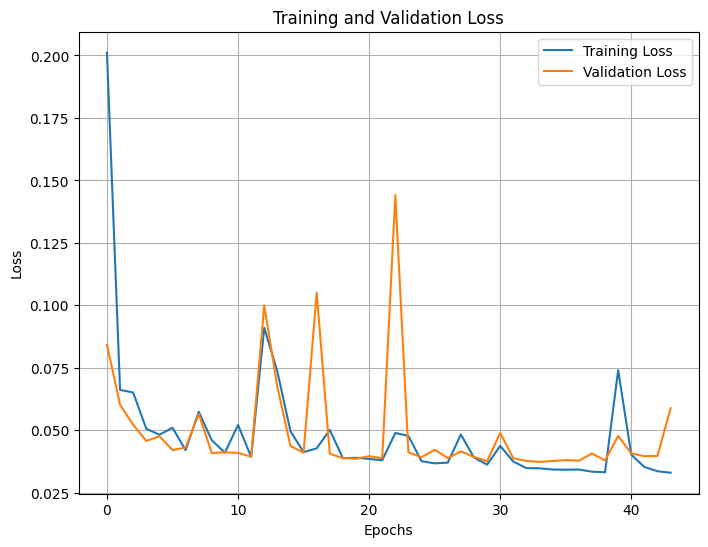

In [35]:
# --- Plot the Loss Curves ---
plt.figure(figsize=(8, 6))
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [36]:
evaluate_model_on_test(model, test_loader)

/tmp/ipykernel_804144/3688939933.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  drunet.load_state_dict(torch.load('Shot_drunet_run1.pt'))


Test Loss: 0.0376, Average PSNR: 30.1185, Average SSIM: 0.8738


/tmp/ipykernel_804144/3055369813.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('Shot_drunet_run1.pt'))
Clipping input data to the vali

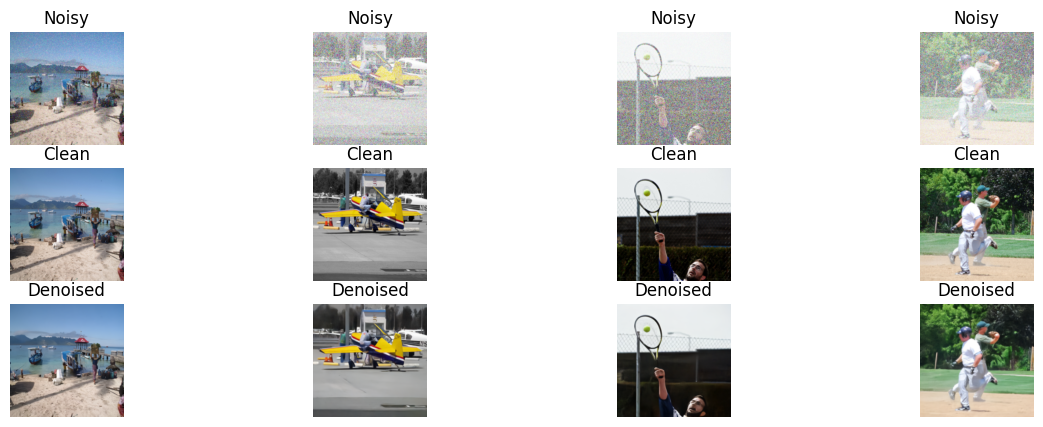

In [37]:
# Set the model to evaluation mode
model.load_state_dict(torch.load('Shot_drunet_run1.pt'))
model.to(device)
# Set the model to evaluation mode
model.eval()

# Get a few images from the test set
with torch.no_grad():
    # Get a single batch from the test loader
    noisy_images, clean_images = next(iter(test_loader))
    
    # Move to the appropriate device
    noisy_images = noisy_images.to(device)
    clean_images = clean_images.to(device)

    # Pass the noisy images through the drunet
    denoised_images = model(noisy_images,0.0)

# Convert to numpy for visualization
noisy_images_np = noisy_images.cpu().numpy()
clean_images_np = clean_images.cpu().numpy()
denoised_images_np = denoised_images.cpu().numpy()

# Function to visualize images
def plot_images(noisy, clean, denoised, num_images=4):
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        # Noisy image
        plt.subplot(3, num_images, i + 1)
        plt.imshow(noisy[i].transpose(1, 2, 0))
        plt.title("Noisy")
        plt.axis("off")

        # Clean image
        plt.subplot(3, num_images, i + 1 + num_images)
        plt.imshow(clean[i].transpose(1, 2, 0))
        plt.title("Clean")
        plt.axis("off")

        # Denoised image
        plt.subplot(3, num_images, i + 1 + 2 * num_images)
        plt.imshow(denoised[i].transpose(1, 2, 0))
        plt.title("Denoised")
        plt.axis("off")
    
    plt.show()

# Plot the images
plot_images(noisy_images_np, clean_images_np, denoised_images_np, num_images=4)

In [38]:
image_path = 'denoising_dataset/Shot-noise/L5/COCO_val2014_000000000074.jpg'
noisy_image = Image.open(image_path)

In [39]:
# Define transformations to convert the image to tensor
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts the image to [0, 1] range and converts to tensor
    transforms.Resize((224, 224)),  # Resizes the image if necessary
])

# Apply transformation and add batch dimension (batch size 1)
noisy_image_tensor = transform(noisy_image).unsqueeze(0)  # Shape: [1, channels, height, width]

In [40]:
# Make sure the model is in evaluation mode
model.eval()

# If using a GPU, move the image tensor to the GPU
noisy_image_tensor = noisy_image_tensor.to('cuda')  # Use 'cpu' if no GPU is available

# Perform inference without computing gradients
with torch.no_grad():
    denoised_image = model(noisy_image_tensor,0.0)

# The output denoised_image will be a tensor, shape: [1, channels, height, width]
print(denoised_image.shape)

torch.Size([1, 3, 224, 224])


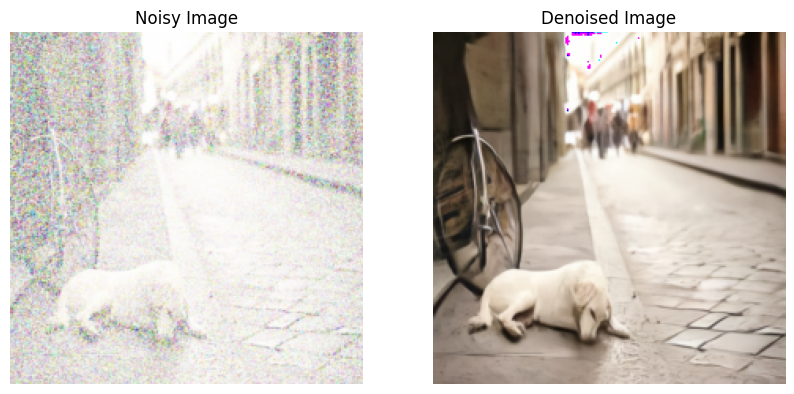

In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms as T

# Move the output back to CPU if using GPU
denoised_image = denoised_image.cpu()
noisy_image_tensor = noisy_image_tensor.cpu()

# Remove batch dimensions for both images
noisy_image = noisy_image_tensor.squeeze(0)  # Shape: [channels, height, width]
denoised_image = denoised_image.squeeze(0)  # Shape: [channels, height, width]

# Convert both tensors to PIL images
noisy_image = T.ToPILImage()(noisy_image)
denoised_image = T.ToPILImage()(denoised_image)

# Create directory if it doesn't exist
output_directory = 'Shot/'

# Define the path to save the denoised image
output_path = os.path.join(output_directory, 'denoised_COCO_val2014_000000000074_L5.jpg')

# Save the denoised image
denoised_image.save(output_path)

# Plot both images side by side
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Display noisy image
axs[0].imshow(noisy_image)
axs[0].axis('off')
axs[0].set_title('Noisy Image')

# Display denoised image
axs[1].imshow(denoised_image)
axs[1].axis('off')
axs[1].set_title('Denoised Image')

# Show the figure
plt.show()

torch.Size([1, 3, 224, 224])


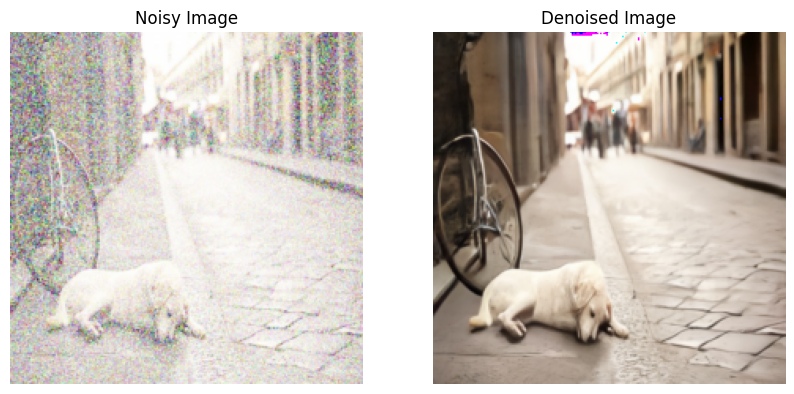

In [ ]:
image_path = 'denoising_dataset/Shot-noise/L4/COCO_val2014_000000000074.jpg'
noisy_image = Image.open(image_path)

# Define transformations to convert the image to tensor
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts the image to [0, 1] range and converts to tensor
    transforms.Resize((224, 224)),  # Resizes the image if necessary
])

# Apply transformation and add batch dimension (batch size 1)
noisy_image_tensor = transform(noisy_image).unsqueeze(0)  # Shape: [1, channels, height, width]

# Make sure the model is in evaluation mode
model.eval()

# If using a GPU, move the image tensor to the GPU
noisy_image_tensor = noisy_image_tensor.to('cuda')  # Use 'cpu' if no GPU is available

# Perform inference without computing gradients
with torch.no_grad():
    denoised_image = model(noisy_image_tensor,0.0)

# The output denoised_image will be a tensor, shape: [1, channels, height, width]
print(denoised_image.shape)

denoised_image = denoised_image.cpu()
noisy_image_tensor = noisy_image_tensor.cpu()

# Remove batch dimensions for both images
noisy_image = noisy_image_tensor.squeeze(0)  # Shape: [channels, height, width]
denoised_image = denoised_image.squeeze(0)  # Shape: [channels, height, width]

# Convert both tensors to PIL images
noisy_image = T.ToPILImage()(noisy_image)
denoised_image = T.ToPILImage()(denoised_image)

# Create directory if it doesn't exist
output_directory = 'Shot/'

# Define the path to save the denoised image
output_path = os.path.join(output_directory, 'denoised_COCO_val2014_000000000074_L4.jpg')

# Save the denoised image
denoised_image.save(output_path)

# Plot both images side by side
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Display noisy image
axs[0].imshow(noisy_image)
axs[0].axis('off')
axs[0].set_title('Noisy Image')

# Display denoised image
axs[1].imshow(denoised_image)
axs[1].axis('off')
axs[1].set_title('Denoised Image')

# Show the figure
plt.show()

torch.Size([1, 3, 224, 224])


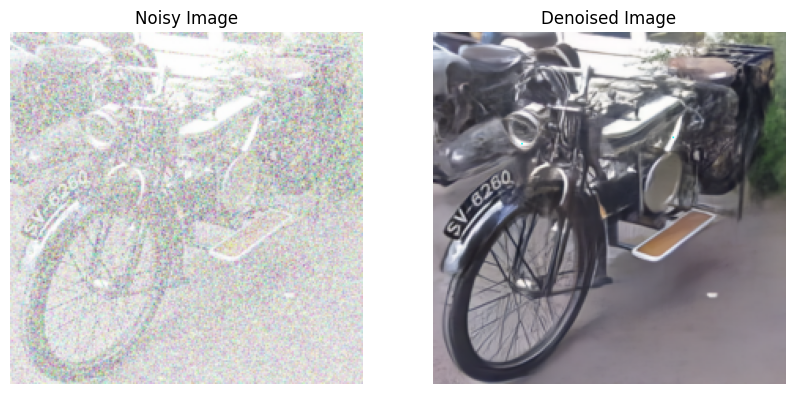

In [ ]:
image_path = 'denoising_dataset/Shot-noise/L5/COCO_val2014_000000000073.jpg'
noisy_image = Image.open(image_path)

#

# Define transformations to convert the image to tensor
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts the image to [0, 1] range and converts to tensor
    transforms.Resize((224, 224)),  # Resizes the image if necessary
])

# Apply transformation and add batch dimension (batch size 1)
noisy_image_tensor = transform(noisy_image).unsqueeze(0)  # Shape: [1, channels, height, width]

# Make sure the model is in evaluation mode
model.eval()

# If using a GPU, move the image tensor to the GPU
noisy_image_tensor = noisy_image_tensor.to('cuda')  # Use 'cpu' if no GPU is available

# Perform inference without computing gradients
with torch.no_grad():
    denoised_image = model(noisy_image_tensor,0.0)



# The output denoised_image will be a tensor, shape: [1, channels, height, width]
print(denoised_image.shape)

denoised_image = denoised_image.cpu()
noisy_image_tensor = noisy_image_tensor.cpu()

# Remove batch dimensions for both images
noisy_image = noisy_image_tensor.squeeze(0)  # Shape: [channels, height, width]
denoised_image = denoised_image.squeeze(0)  # Shape: [channels, height, width]

# Convert both tensors to PIL images
noisy_image = T.ToPILImage()(noisy_image)
denoised_image = T.ToPILImage()(denoised_image)

# Create directory if it doesn't exist
output_directory = 'Shot/'

# Define the path to save the denoised image
output_path = os.path.join(output_directory, 'denoised_COCO_val2014_000000000074_L5.jpg')

# Save the denoised image
denoised_image.save(output_path)

# Plot both images side by side
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Display noisy image
axs[0].imshow(noisy_image)
axs[0].axis('off')
axs[0].set_title('Noisy Image')

# Display denoised image
axs[1].imshow(denoised_image)
axs[1].axis('off')
axs[1].set_title('Denoised Image')

# Show the figure
plt.show()

torch.Size([1, 3, 224, 224])


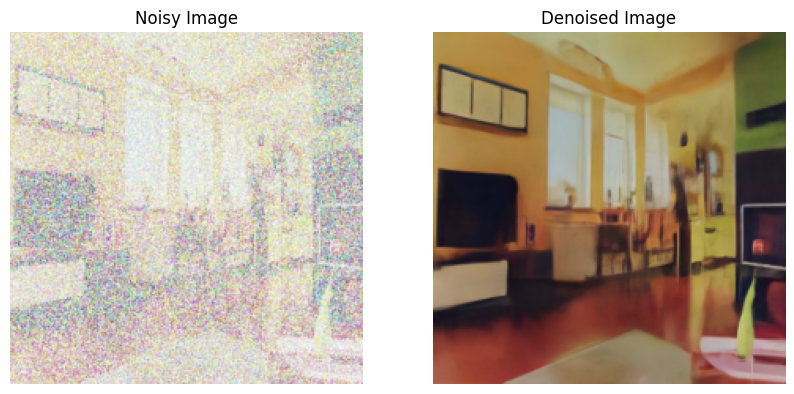

In [44]:
image_path = 'denoising_dataset/Shot-noise/L5/COCO_val2014_000000000139.jpg'
noisy_image = Image.open(image_path)

# Define transformations to convert the image to tensor
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts the image to [0, 1] range and converts to tensor
    transforms.Resize((224, 224)),  # Resizes the image if necessary
])

# Apply transformation and add batch dimension (batch size 1)
noisy_image_tensor = transform(noisy_image).unsqueeze(0)  # Shape: [1, channels, height, width]

# Make sure the model is in evaluation mode
model.eval()

# If using a GPU, move the image tensor to the GPU
noisy_image_tensor = noisy_image_tensor.to('cuda')  # Use 'cpu' if no GPU is available

# Perform inference without computing gradients
with torch.no_grad():
    denoised_image = model(noisy_image_tensor,0.0)

# The output denoised_image will be a tensor, shape: [1, channels, height, width]
print(denoised_image.shape)


# Move the tensors back to the CPU
denoised_image = denoised_image.cpu()
noisy_image_tensor = noisy_image_tensor.cpu()

# Remove batch dimensions for both images
noisy_image = noisy_image_tensor.squeeze(0)  # Shape: [channels, height, width]
denoised_image = denoised_image.squeeze(0)  # Shape: [channels, height, width]

# Convert both tensors to PIL images
noisy_image = T.ToPILImage()(noisy_image)
denoised_image = T.ToPILImage()(denoised_image)


# Create directory if it doesn't exist
output_directory = '[denoised image test]'

# Define the path to save the denoised image
output_path = os.path.join(output_directory, 'denoised_COCO_val2014_000000000139.jpg')

# Save the denoised image
denoised_image.save(output_path)

# Plot both images side by side
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Display noisy image
axs[0].imshow(noisy_image)
axs[0].axis('off')
axs[0].set_title('Noisy Image')

# Display denoised image
axs[1].imshow(denoised_image)
axs[1].axis('off')
axs[1].set_title('Denoised Image')

# Show the figure
plt.show()

torch.Size([1, 3, 224, 224])


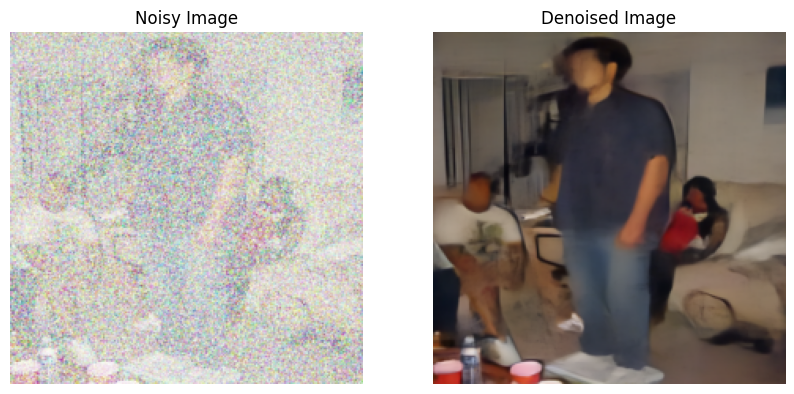

In [45]:
image_path = 'denoising_dataset/Shot-noise/L5/COCO_val2014_000000000241.jpg'
noisy_image = Image.open(image_path)

# Define transformations to convert the image to tensor
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts the image to [0, 1] range and converts to tensor
    transforms.Resize((224, 224)),  # Resizes the image if necessary
])

# Apply transformation and add batch dimension (batch size 1)
noisy_image_tensor = transform(noisy_image).unsqueeze(0)  # Shape: [1, channels, height, width]

# Make sure the model is in evaluation mode
model.eval()

# If using a GPU, move the image tensor to the GPU
noisy_image_tensor = noisy_image_tensor.to('cuda')  # Use 'cpu' if no GPU is available

# Perform inference without computing gradients
with torch.no_grad():
    denoised_image = model(noisy_image_tensor,0.0)

# The output denoised_image will be a tensor, shape: [1, channels, height, width]
print(denoised_image.shape)

denoised_image = denoised_image.cpu()
noisy_image_tensor = noisy_image_tensor.cpu()

# Remove batch dimensions for both images
noisy_image = noisy_image_tensor.squeeze(0)  # Shape: [channels, height, width]
denoised_image = denoised_image.squeeze(0)  # Shape: [channels, height, width]

# Convert both tensors to PIL images
noisy_image = T.ToPILImage()(noisy_image)
denoised_image = T.ToPILImage()(denoised_image)

# Plot both images side by side
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Display noisy image
axs[0].imshow(noisy_image)
axs[0].axis('off')
axs[0].set_title('Noisy Image')

# Display denoised image
axs[1].imshow(denoised_image)
axs[1].axis('off')
axs[1].set_title('Denoised Image')

# Show the figure
plt.show()